# Autoencoder for Image Reconstruction

## Autoencoder Implementation

> checkout the ```autoencoder.py``` file

## Training and Visualization on MNIST

In [2]:
from sklearn.datasets import fetch_openml
import numpy as np
from autoencoder import Autoencoder, train_autoencoder
import matplotlib.pyplot as plt

Initial distribution:
Training set: {'0': np.int64(5923), '1': np.int64(6742), '2': np.int64(5958), '3': np.int64(6131), '4': np.int64(5842), '5': np.int64(5421), '6': np.int64(5918), '7': np.int64(6265), '8': np.int64(5851), '9': np.int64(5949)}
Test set: {'0': np.int64(980), '1': np.int64(1135), '2': np.int64(1032), '3': np.int64(1010), '4': np.int64(982), '5': np.int64(892), '6': np.int64(958), '7': np.int64(1028), '8': np.int64(974), '9': np.int64(1009)}


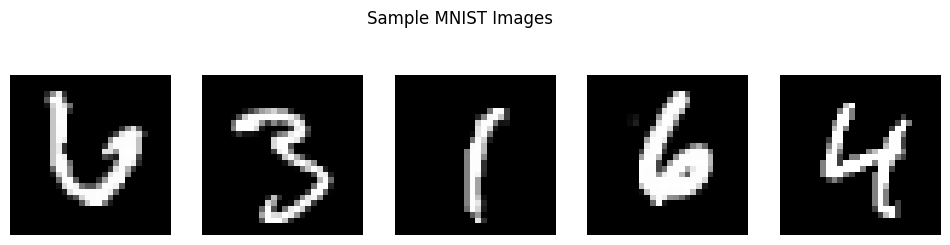

In [4]:
# mnist dataset

class MNISTDataset:
    """
    Dataset class for MNIST digits using scikit-learn.
    Returns flattened images with normalized pixel values.
    """
    def __init__(self, split='train'):
        """
        Initialize the dataset with either training or test split.
        
        Args:
            split (str): Either 'train' or 'test'
        """
        # Load MNIST data from openml
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
        
        # Normalize pixel values to [0, 1] if not already normalized
        X = X.astype('float32') / 255.0
        
        # Split into train and test (first 60000 for training, rest for testing)
        if split == 'train':
            self.images = X[:60000].reshape(-1, 28, 28)
            self.labels = y[:60000]
        else:
            self.images = X[60000:].reshape(-1, 28, 28)
            self.labels = y[60000:]
        
        # Store original image dimensions
        self.height, self.width = self.images.shape[1:]
        self.num_samples = len(self.images)
        
        # Flatten images
        self.flattened_images = self.images.reshape(self.num_samples, -1)
        
        # Create indices for shuffling
        self.indices = np.arange(self.num_samples)
    
    def shuffle(self):
        """Shuffle the dataset order."""
        np.random.seed(42)
        np.random.shuffle(self.indices)
    
    def get_all_samples(self):
        """
        Get all data points in shuffled order.
        For autoencoder, input and target are the same.
        """
        self.shuffle()
        return (self.flattened_images[self.indices], 
                self.flattened_images[self.indices])
    
    def reconstruct_image(self, flattened):
        """
        Reshape flattened array back to original image dimensions.
        
        Args:
            flattened: Flattened image array of shape (784,) or (N, 784)
        Returns:
            Reshaped image(s) of shape (28, 28) for single image or (N, 28, 28) for batch
        """
        if len(flattened.shape) == 1:
            # Single image
            return flattened.reshape(self.height, self.width)
        else:
            # Batch of images
            return flattened.reshape(-1, self.height, self.width)

    def get_random_batch(self, batch_size):
        """
        Get a random batch of samples.
        For autoencoder, input and target are the same.
        """
        idx = np.random.choice(self.num_samples, batch_size)
        return (self.flattened_images[idx], 
                self.flattened_images[idx])
    
    def __len__(self):
        """Return the number of samples in the dataset."""
        return self.num_samples
    
    def __getitem__(self, idx):
        """
        Enable indexing functionality for the dataset.
        
        Args:
            idx: Index or array of indices
        Returns:
            Flattened images for the requested indices
        """
        return self.flattened_images[idx]
    
    def analyze_distribution(self):
        """
        Analyze the distribution of samples across different labels.
        """
        unique_labels, counts = np.unique(self.labels, return_counts=True)
        distribution = dict(zip(unique_labels, counts))
        return distribution
    
    def balance_dataset(self, samples_per_class=None):
        """
        Balance the dataset to have equal number of samples per class.
        
        Args:
            samples_per_class: Number of samples to keep per class. 
                             If None, uses the minimum count across classes.
        """
        distribution = self.analyze_distribution()
        if samples_per_class is None:
            samples_per_class = min(distribution.values())
        
        balanced_indices = []
        for label in distribution.keys():
            label_indices = np.where(self.labels == label)[0]
            selected_indices = np.random.choice(
                label_indices, 
                samples_per_class, 
                replace=False
            )
            balanced_indices.extend(selected_indices)
        
        # Shuffle the balanced indices
        np.random.shuffle(balanced_indices)
        
        # Update dataset
        self.images = self.images[balanced_indices]
        self.labels = self.labels[balanced_indices]
        self.flattened_images = self.flattened_images[balanced_indices]
        self.num_samples = len(self.labels)
        self.indices = np.arange(self.num_samples)
        
        return self.analyze_distribution()

# Create and analyze datasets
train_dataset = MNISTDataset(split='train')
test_dataset = MNISTDataset(split='test')

print("Initial distribution:")
print("Training set:", train_dataset.analyze_distribution())
print("Test set:", test_dataset.analyze_distribution())

# Optional: Balance datasets
train_samples_per_class = 5000  # You can adjust this number
test_samples_per_class = 1000   # You can adjust this number

# print("\nBalancing datasets...")
# train_dist = train_dataset.balance_dataset(train_samples_per_class)
# test_dist = test_dataset.balance_dataset(test_samples_per_class)

# print("\nBalanced distribution:")
# print("Training set:", train_dist)
# print("Test set:", test_dist)

# Example visualization
import matplotlib.pyplot as plt

# Get a random batch
batch_x, _ = train_dataset.get_random_batch(5)

# Plot original images
plt.figure(figsize=(12, 3))
for i in range(5):
    # Note: using batch_x[i] which is (784,) shaped
    img = train_dataset.reconstruct_image(batch_x[i])  # Will be (28, 28)
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.suptitle('Sample MNIST Images')
plt.show()

In [5]:
autoencoder = Autoencoder(input_dim=28*28, hidden_dims=[256, 128 , 64], latent_dim=32)

#### Training

In [6]:
results = train_autoencoder(autoencoder=autoencoder,
                            dataset=train_dataset,
                            batch_size=256,
                            grad_accumulation_steps=1,
                            max_epochs=500,
                            patience=100,
                            relative_loss_threshold=1e-3,
                            run_name="mnist_autoencoder",
                            save_model=True,
                            )

Starting autoencoder training: mnist_autoencoder
Results saved to runs/mnist_autoencoder/
Training completed: 500 epochs, 30000000 samples
Final loss: 0.017717


#### Visvualisation

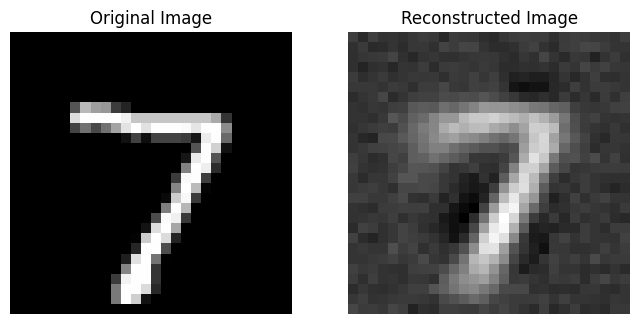

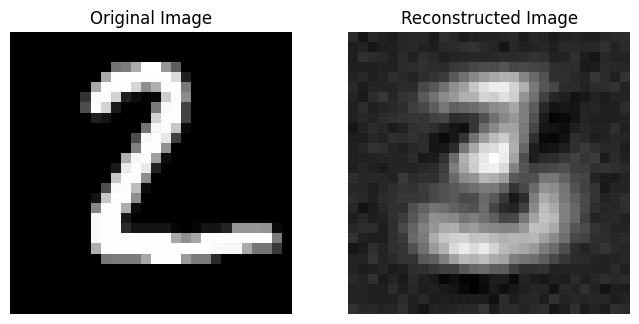

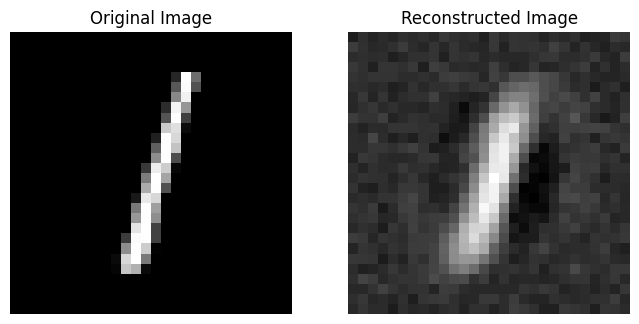

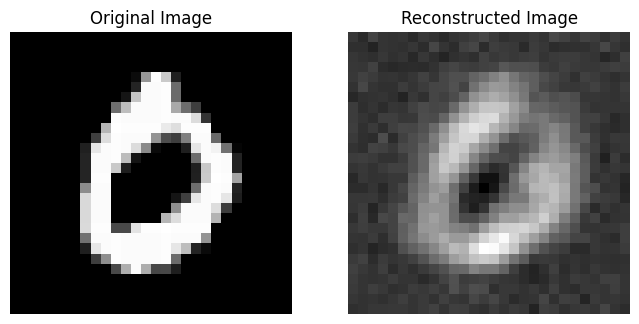

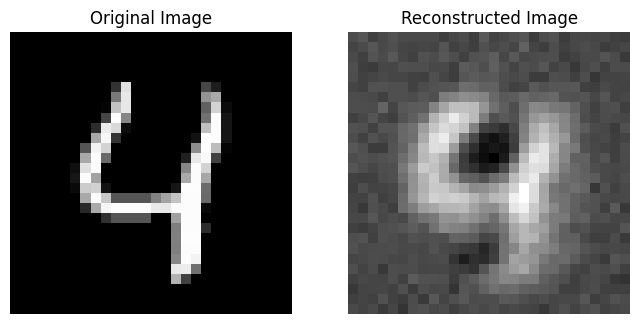

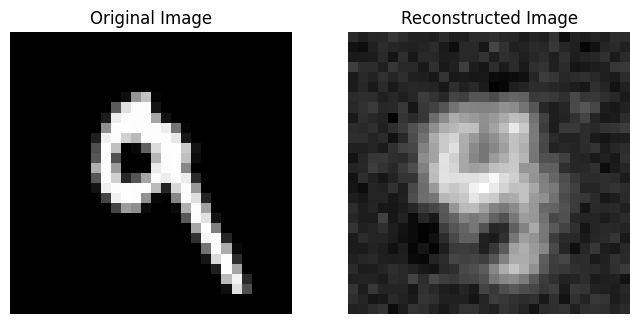

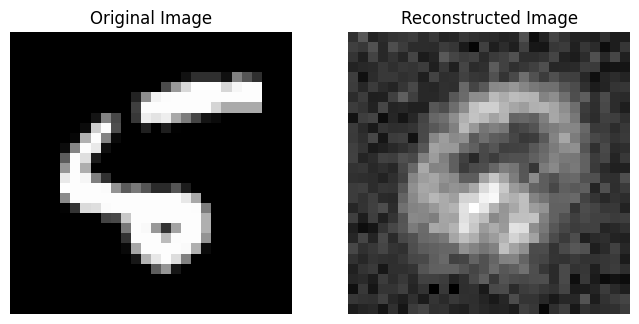

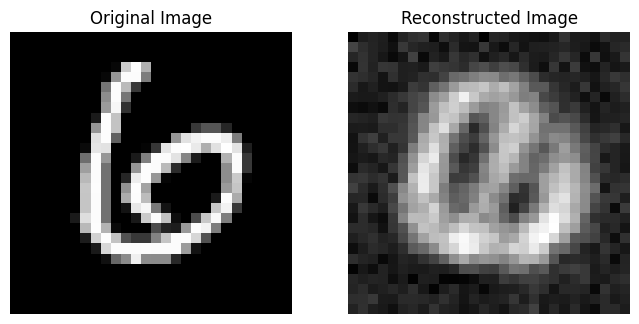

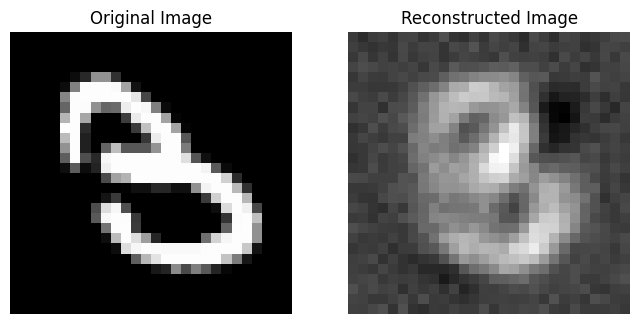

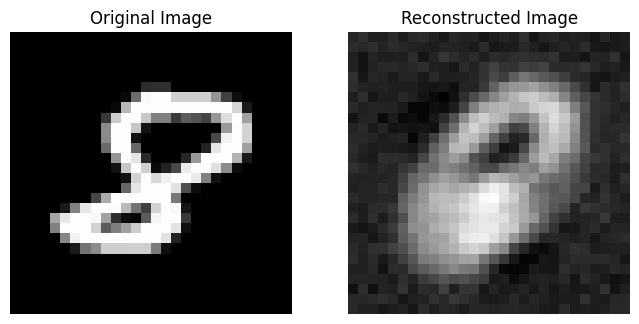

In [14]:
#visualise the true and reconstructed image of all 10 numbers


hash = [False]*10
for i in range(len(test_dataset)):
    label = int(test_dataset.labels[i])
    if not hash[label]:
        test_x = test_dataset[i].reshape(1,-1)
        hash[label] = True
        bottleneck = autoencoder.encode(test_x)
        reconstructed = autoencoder.decode(bottleneck)

        true_image = test_dataset.reconstruct_image(test_x)
        true_image = true_image.reshape(28,28)
        reconstructed_image = test_dataset.reconstruct_image(reconstructed)
        reconstructed_image = reconstructed_image.reshape(28,28)
        # print(reconstructed_image.shape)
        fig , axes = plt.subplots(1,2, figsize=(8,4))
        axes[0].imshow(true_image, cmap='gray')
        axes[0].set_title("Original Image")
        axes[0].axis('off')
        axes[1].imshow(reconstructed_image, cmap='gray')    
        axes[1].set_title("Reconstructed Image")
        axes[1].axis('off')
        plt.show()
    if all(hash):
        break
